# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

**Note:** Megaline rounds seconds up to minutes, and megabytes to gigabytes. For calls, each individual call is rounded up: even if the call lasted just one second, it will be counted as one minute. For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.

2 main hypothesis to be checked here: 

* Revenues from the 2 plans are different, so one of them is more profitable than other, and shoul be advertized more;
* Users from the NY-NJ-PA area has different behaviour in terms of messaging, calling and mobile internet usage, so the revenue from them differs from the mean revenue from users of ather areas.

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy import stats
import scipy

## Data loading

In [2]:
# Load the data files into different DataFrames
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_internet = pd.read_csv('/datasets/megaline_internet.csv')
df_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_plans = pd.read_csv('/datasets/megaline_plans.csv')
df_users = pd.read_csv('/datasets/megaline_users.csv')

## Data preparation

## Plans

`plan_name` — calling plan name

`usd_monthly_fee` — monthly charge in US dollars

`minutes_included` — monthly minute allowance

`messages_included` — monthly text allowance

`mb_per_month_included` — data volume allowance (in megabytes)

`usd_per_minute` — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)

`usd_per_message` — price per text after exceeding the package limits

`usd_per_gb` — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

In [3]:
# Print the general/summary information about the plans' DataFrame
df_plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Print a sample of data for plans
df_plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


This dataframe describes a plan terms. It contains plan name, included amounts of minutes, messages and internet traffic, as well as cost of services, provided by the operator.

No *Nans* found, all columns are in appropriate datatypes. The only minor thing can be done here - enrichment of the data with a column of internet traffic included per month in **Gb**, as payments are calculated for rounded up **Gb**s used. 

### Data fixing

No fixing is needed for this dataset.

### Data enrichment

[Add additional factors to the data if you believe they might be useful.]

In [5]:
df_plans['gb_per_month_included'] = (df_plans['mb_per_month_included']/1024).astype(int)
df_plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


As included traffic is now in Gb, it should make futher calculations easier.

## Users

`user_id` — unique user identifier

`first_name` — user's name

`last_name` — user's last name

`age` — user's age (years)

`reg_date` — subscription date (dd, mm, yy)

`churn_date` — the date the user stopped using the service (if the value is missing, the calling plan was being used when this database was extracted)

`city` — user's city of residence

`plan` — calling plan name

In [6]:
# Print the general/summary information about the users' DataFrame
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Print a sample of data for users
df_users.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Data contains full info for individual users. 

No missing values found (exept for `churn_date` column, but there it states, that person still use Megaline service).
Date columns `reg_date` and `churn_date` contains info in object type. For futher analysis it is best to turn it into the datetime type.

Also from `city` column information on region can be extracted to another column to make the hypothesis testing easier.


In this dataframe the apparent duplicates should be checked:

In [8]:
df_users.duplicated().sum()

0

No duplicative data found.

### Data fixing

[Fix obvious issues with the data given the initial observations.]

In [9]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format = '%Y-%m-%d')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [10]:
df_users['city'][0]

'Atlanta-Sandy Springs-Roswell, GA MSA'

### Data enrichment

For extracting region from the `city` column I will take the whole strings from the column cells, split them by the ',' symbol, take only second part of the resulting list and drop last 4 symbols (' MSA') and first 1 spacing from it:

In [11]:
def region_extractor(row):
    return row.split(',')[1][1:-4]

In [12]:
df_users['region'] = df_users['city'].apply(region_extractor)
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,region
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,GA
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,WA
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,NV
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,OK
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,WA


In [13]:
df_users['region'].unique()

array(['GA', 'WA', 'NV', 'OK', 'TX', 'CA', 'MI', 'FL', 'OH', 'IL-IN-WI',
       'TN', 'NY-NJ-PA', 'PA', 'DC-VA-MD-WV', 'IN', 'NE-IA',
       'PA-NJ-DE-MD', 'AL', 'NC-SC', 'CO', 'NM', 'MA-NH', 'AZ', 'OR-WA',
       'OH-KY-IN', 'SC', 'NY', 'TN-MS-AR', 'KY-IN', 'RI-MA', 'UT', 'HI',
       'CT', 'LA', 'VA-NC', 'MD', 'WI', 'VA', 'MO-IL', 'MN-WI', 'MO-KS',
       'NC'], dtype=object)

## Calls

`id` — unique call identifier

`call_date` — call date

`duration` — call duration (in minutes)

`user_id` — the identifier of the user making the call

In [14]:
# Print the general/summary information about the calls' DataFrame
df_calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [15]:
# Print a sample of data for calls
df_calls.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [16]:
df_calls.duplicated().sum()

0

Data dosn't contain any *Nans*. No apparent duplicates found.

`call_date` column should be in datetime type and `call_month` column will be created for easy futher manipulations. 

`duration` column contains minutes with decimals, but the cost will be calculated on rounded up duration in minutes.

`id` column contain information on call id, which has user_id inside it. For merging dataframes in future, it is better to create another column with `user_id` only.


### Data fixing

In [17]:
# changing data type
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%d')
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [18]:
# rounding up the duration and changing datatype to int:
df_calls['duration'] = df_calls['duration'].apply(np.ceil).astype('int')
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


### Data enrichment

For extracting `user_id` form the call `id` column, the `id` string should be splitted by '_' and first part of the list taken:

In [19]:
def user_id_extractor(row):
    return row.split('_')[0]

In [20]:
df_calls['user_id'] = df_calls['id'].apply(user_id_extractor)

In [21]:
df_calls['month'] = df_calls['call_date'].dt.month
df_calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12


## Messages

`id` — unique text message identifier

`message_date` — text message date

`user_id` — the identifier of the user sending the text

In [22]:
# Print the general/summary information about the messages' DataFrame

df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [23]:
# Print a sample of data for messages

df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [24]:
df_messages.duplicated().sum()

0

This dataframe has no *Nans* and already has a column `user_id` . The only thing to be done here: changing the `message_date` into the datetime type and `message_month` column should be created.

### Data fixing

In [25]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Data enrichment

In [26]:
df_messages['month'] = df_messages['message_date'].dt.month
df_messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


## Internet

`id` — unique session identifier

`mb_used` — the volume of data spent during the session (in megabytes)

`session_date` — web session date

`user_id` — user identifier

In [27]:
# Print the general/summary information about the internet DataFrame
df_internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [28]:
# Print a sample of data for the internet traffic
df_internet.head()


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [29]:
df_internet.duplicated().sum()

0

Again, no missing or duplicated values found. 

The column `user_id` already present.

`mb_used` can be enriched with a column, where **Mb** are turned to **Gb**, which can make further analysis a bit easier.

`session_date` shoulb be turned into datetime type and `internet_session_month` column will be created for analysis.

### Data fixing

In [30]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


### Data enrichment

In [31]:
df_internet['gb_used'] = df_internet['mb_used']/1024
df_internet.head()

,id,user_id,session_date,mb_used,gb_used
0,1000_13,1000,2018-12-29,89.86,0.087754
1,1000_204,1000,2018-12-31,0.00,0.000000
2,1000_379,1000,2018-12-28,660.40,0.644922
3,1000_413,1000,2018-12-26,270.99,0.264639
4,1000_442,1000,2018-12-27,880.22,0.859590


In [32]:
df_internet['month'] = df_internet['session_date'].dt.month
df_internet.head()

,id,user_id,session_date,mb_used,gb_used,month
0,1000_13,1000,2018-12-29,89.86,0.087754,12
1,1000_204,1000,2018-12-31,0.00,0.000000,12
2,1000_379,1000,2018-12-28,660.40,0.644922,12
3,1000_413,1000,2018-12-26,270.99,0.264639,12
4,1000_442,1000,2018-12-27,880.22,0.859590,12


Here we can't drop decimals from the `gb_used` column, as here we have recordings for daily sessions, and cost of the traffiking calculated only with the month's traffic sum.

## Study plan conditions

In [33]:
# Print out the plan conditions and make sure they are clear for you
df_plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


`plan_name` — calling plan name

`usd_monthly_fee` — monthly charge in US dollars

`minutes_included` — monthly minute allowance

`messages_included` — monthly text allowance

`mb_per_month_included` — data volume allowance (in megabytes)

`usd_per_minute` — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)

`usd_per_message` — price per text after exceeding the package limits

`usd_per_gb` — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)

## Per user data aggregating

In [34]:
# Calculate the number of calls made by each user per month. Save the result.

df_calls_grouped = df_calls.groupby(['user_id','month'])['id'].count().reset_index().rename({'id':'calls_count'},axis = 1)
df_calls_grouped.head()

,user_id,month,calls_count
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64


In [35]:
df_calls_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      2258 non-null   object
 1   month        2258 non-null   int64 
 2   calls_count  2258 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 53.0+ KB


In [36]:
# Calculate the amount of minutes spent by each user per month. Save the result.

df_minutes_grouped = df_calls.groupby(['user_id','month'])['duration'].sum().reset_index().rename({'duration':'minutes_total_spent'},axis = 1)
df_minutes_grouped.head()


,user_id,month,minutes_total_spent
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426


In [37]:
df_minutes_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              2258 non-null   object
 1   month                2258 non-null   int64 
 2   minutes_total_spent  2258 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 53.0+ KB


In [38]:
# Calculate the number of messages sent by each user per month. Save the result.

df_messages_grouped = df_messages.groupby(['user_id','month'])['id'].count().reset_index().rename({'id':'messages_count'},axis = 1)
df_messages_grouped.head()

,user_id,month,messages_count
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


In [39]:
df_messages_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         1806 non-null   int64
 1   month           1806 non-null   int64
 2   messages_count  1806 non-null   int64
dtypes: int64(3)
memory usage: 42.5 KB


In [40]:
# Calculate the volume of internet traffic used by each user per month. Save the result.

df_internet_grouped = df_internet.groupby(['user_id','month'])['gb_used'].sum().reset_index().rename({'gb_used':'gb_total_spent'},axis = 1)
df_internet_grouped.head()


,user_id,month,gb_total_spent
0,1000,12,1.856904
1,1001,8,6.756982
2,1001,9,13.002754
3,1001,10,21.807119
4,1001,11,18.070605


In **df_internet_grouped** dataframe now we can round up the months' traffiking amounts:

In [41]:
df_internet_grouped['gb_total_spent'] = df_internet_grouped['gb_total_spent'].apply(np.ceil).astype('int')
df_internet_grouped.head()

,user_id,month,gb_total_spent
0,1000,12,2
1,1001,8,7
2,1001,9,14
3,1001,10,22
4,1001,11,19


In [42]:
df_internet_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         2277 non-null   int64
 1   month           2277 non-null   int64
 2   gb_total_spent  2277 non-null   int64
dtypes: int64(3)
memory usage: 53.5 KB


Before aggregating data I've noticed, that in some subsets `user_id` present in *int* type, while on other it is in *object* type.
For successfull aggregation small fixing needed:

In [43]:
datasets_to_merge = [df_calls_grouped,df_minutes_grouped,df_messages_grouped,df_internet_grouped]

for dataset in datasets_to_merge:
    dataset['user_id'] = dataset['user_id'].astype('int')

In [44]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
user_consumption = datasets_to_merge[0]
for dataset in datasets_to_merge[1:]:
    user_consumption = user_consumption.merge(dataset, on=['user_id', 'month'], how = 'outer')
    
user_consumption.head()

,user_id,month,calls_count,minutes_total_spent,messages_count,gb_total_spent
0,1000,12,16.0,124.0,11.0,2.0
1,1001,8,27.0,182.0,30.0,7.0
2,1001,9,49.0,315.0,44.0,14.0
3,1001,10,65.0,393.0,53.0,22.0
4,1001,11,64.0,426.0,36.0,19.0


In [45]:
user_consumption.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              2293 non-null   int64  
 1   month                2293 non-null   int64  
 2   calls_count          2258 non-null   float64
 3   minutes_total_spent  2258 non-null   float64
 4   messages_count       1806 non-null   float64
 5   gb_total_spent       2277 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 125.4 KB


In [46]:
# Add the plan information

user_consumption = user_consumption.merge(df_users[['user_id','plan']], on=['user_id']).merge(df_plans, left_on = 'plan', right_on = 'plan_name')

In [47]:
user_consumption.head()

,user_id,month,calls_count,minutes_total_spent,messages_count,gb_total_spent,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,1000,12,16.0,124.0,11.0,2.0,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,30
1,1006,11,2.0,10.0,15.0,3.0,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,30
2,1006,12,9.0,59.0,139.0,32.0,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,30
3,1008,10,71.0,476.0,21.0,17.0,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,30
4,1008,11,63.0,446.0,37.0,24.0,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate,30


In [48]:
user_consumption.drop('plan_name', axis=1, inplace=True)
user_consumption.head()

,user_id,month,calls_count,minutes_total_spent,messages_count,gb_total_spent,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,1000,12,16.0,124.0,11.0,2.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30
1,1006,11,2.0,10.0,15.0,3.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30
2,1006,12,9.0,59.0,139.0,32.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30
3,1008,10,71.0,476.0,21.0,17.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30
4,1008,11,63.0,446.0,37.0,24.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30


Now the whole data is collected properly into one dataset...

In [49]:
# Calculate the monthly revenue for each user
# Whole calculation could be done in a function
# for that I will create a dictionary with column names and there indexes for a bit easier function writing

In [50]:
dict_for_function = {}
for column_name in ['minutes_total_spent','minutes_included','usd_per_minute', 'messages_count','messages_included','usd_per_message','gb_total_spent','gb_per_month_included','usd_per_gb','usd_monthly_pay']:
    column_index = user_consumption.columns.get_loc(column_name)
    dict_for_function[column_name]=column_index
dict_for_function

{'minutes_total_spent': 3,
 'minutes_included': 9,
 'usd_per_minute': 13,
 'messages_count': 4,
 'messages_included': 7,
 'usd_per_message': 12,
 'gb_total_spent': 5,
 'gb_per_month_included': 14,
 'usd_per_gb': 11,
 'usd_monthly_pay': 10}

In [51]:
def month_revenue_calculator (row):
    total_month_revenue = row[dict_for_function['usd_monthly_pay']] # starting with the monthly pay for the plan
    
    # minutes check:
    if (row[dict_for_function['minutes_total_spent']] - row[dict_for_function['minutes_included']]) > 0:
        total_month_revenue += (row[dict_for_function['minutes_total_spent']] - row[dict_for_function['minutes_included']])*row[dict_for_function['usd_per_minute']]
    # messages check:
    if (row[dict_for_function['messages_count']] - row[dict_for_function['messages_included']]) > 0:
        total_month_revenue += (row[dict_for_function['messages_count']] - row[dict_for_function['messages_included']])*row[dict_for_function['usd_per_message']]
    # internet traffic check:
    if (row[dict_for_function['gb_total_spent']] - row[dict_for_function['gb_per_month_included']]) > 0:
        total_month_revenue += (row[dict_for_function['gb_total_spent']] - row[dict_for_function['gb_per_month_included']])*row[dict_for_function['usd_per_gb']]  
    return total_month_revenue

In [52]:
user_consumption['month_revenue'] = user_consumption.apply(month_revenue_calculator, axis = 1)
user_consumption.head()

,user_id,month,calls_count,minutes_total_spent,messages_count,gb_total_spent,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,month_revenue
0,1000,12,16.0,124.0,11.0,2.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30,70.0
1,1006,11,2.0,10.0,15.0,3.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30,70.0
2,1006,12,9.0,59.0,139.0,32.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30,84.0
3,1008,10,71.0,476.0,21.0,17.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30,70.0
4,1008,11,63.0,446.0,37.0,24.0,ultimate,1000,30720,3000,70,7,0.01,0.01,30,70.0


In [53]:
user_consumption.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2293 non-null   int64  
 1   month                  2293 non-null   int64  
 2   calls_count            2258 non-null   float64
 3   minutes_total_spent    2258 non-null   float64
 4   messages_count         1806 non-null   float64
 5   gb_total_spent         2277 non-null   float64
 6   plan                   2293 non-null   object 
 7   messages_included      2293 non-null   int64  
 8   mb_per_month_included  2293 non-null   int64  
 9   minutes_included       2293 non-null   int64  
 10  usd_monthly_pay        2293 non-null   int64  
 11  usd_per_gb             2293 non-null   int64  
 12  usd_per_message        2293 non-null   float64
 13  usd_per_minute         2293 non-null   float64
 14  gb_per_month_included  2293 non-null   int64  
 15  mont

Data is ready, it has most of the columns with no missing values. The biggest amount of *Nans* are found in the `messages_count` column. As those *Nans* were not observed in datasets, from which this data was extracted, we can assum, that some users didn't use some of the services, like sms or outcoming calls or other, which can be realistic + some *Nans* appeared, as some users quited Megaline. 

So far, we can start analyzing users' behaviour. If missing values would create any problems futher, they can be substituted by medians of the given sample (for overall distribution or with grouping by some factors).

## User behaviour study

In [54]:
df_users.groupby('plan')['user_id'].count()

plan
surf        339
ultimate    161
Name: user_id, dtype: int64

In [55]:
user_consumption.query('plan == "ultimate"').describe().T.astype(int)

,count,mean,std,min,25%,50%,75%,max
user_id,720,1253,150,1000,1126,1241,1401,1497
month,720,9,2,1,8,10,11,12
calls_count,713,61,32,2,37,61,80,191
minutes_total_spent,713,434,237,0,263,425,566,1369
messages_count,584,46,32,1,21,41,66,166
gb_total_spent,719,17,7,1,13,17,21,46
messages_included,720,1000,0,1000,1000,1000,1000,1000
mb_per_month_included,720,30720,0,30720,30720,30720,30720,30720
minutes_included,720,3000,0,3000,3000,3000,3000,3000
usd_monthly_pay,720,70,0,70,70,70,70,70


In [56]:
user_consumption.query('plan == "surf"').describe().T.astype(int)

,count,mean,std,min,25%,50%,75%,max
user_id,1573,1242,139,1001,1120,1245,1358,1499
month,1573,9,2,1,8,10,11,12
calls_count,1545,60,31,1,40,60,80,205
minutes_total_spent,1545,436,229,0,279,430,579,1510
messages_count,1222,40,33,1,16,32,54,266
gb_total_spent,1558,16,7,1,12,17,21,70
messages_included,1573,50,0,50,50,50,50,50
mb_per_month_included,1573,15360,0,15360,15360,15360,15360,15360
minutes_included,1573,500,0,500,500,500,500,500
usd_monthly_pay,1573,20,0,20,20,20,20,20


We can notice, that columns with amounts of used services have nearly same means and medians between two plans. This shows us, that users of different plans behave in same way in terms of using telecom services. This needs deeper analysis

### Calls

* Average per month

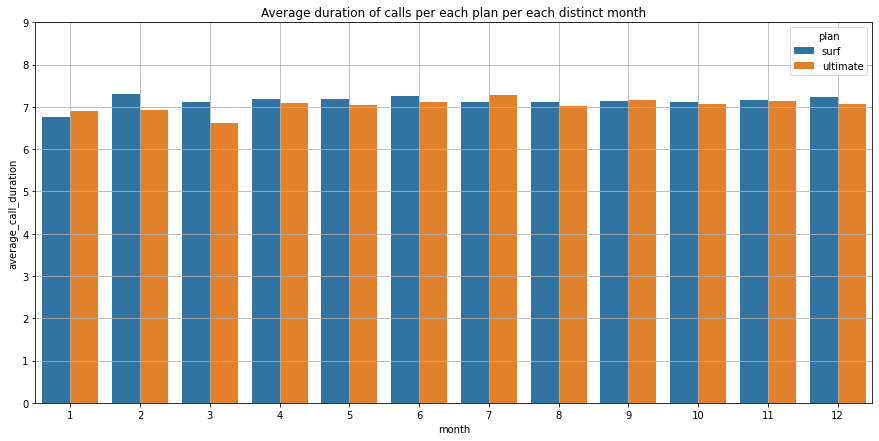

In [57]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.

calls_data_to_plot = user_consumption.groupby(['plan','month'])[['calls_count','minutes_total_spent']].agg('mean').reset_index()
calls_data_to_plot['average_call_duration'] = calls_data_to_plot['minutes_total_spent']/calls_data_to_plot['calls_count']

plt.figure(figsize = (15,7))
plt.ylim(0, 9)
sns.barplot(data = calls_data_to_plot, hue = 'plan', x = 'month', y = 'average_call_duration')
plt.title('Average duration of calls per each plan per each distinct month')
plt.grid()
plt.show()

No real differences can be observed in average duration of calls per each plan per each distinct month, there is a weak tendency for calls to be shorter in January.

* Monthy average

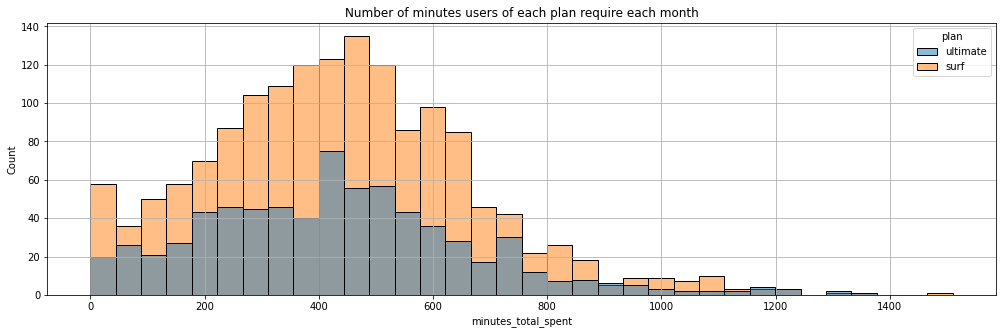

plan
surf        339
ultimate    161
Name: user_id, dtype: int64

In [58]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.

plt.figure(figsize=(17,5))
sns.histplot(user_consumption,x='minutes_total_spent',hue='plan')
plt.title('Number of minutes users of each plan require each month')
plt.grid()
plt.show()
df_users.groupby('plan')['user_id'].count()

Both distributions are strive to nornal with a slight right skewness.

The both distributions show nearly the same trends. The biggest difference odserved only on counts, as:

In [59]:
df_users.groupby('plan')['user_id'].count()

plan
surf        339
ultimate    161
Name: user_id, dtype: int64

users of *surf* plan are twice as big in counts as users of *ultimate* plan.

In [60]:
# Calculate the mean and the variance of the monthly call duration

user_consumption['average_call_duration'] = user_consumption['minutes_total_spent']/user_consumption['calls_count']

print('Variance is:',user_consumption.groupby('plan')['average_call_duration'].var())
print('*'*50)
print('Standard deviation is:',user_consumption.groupby('plan')['average_call_duration'].std())
print('*'*50)
print('Mean is:',user_consumption.groupby('plan')['average_call_duration'].mean())
print('*'*50)
print('Median is:',user_consumption.groupby('plan')['average_call_duration'].median())

Variance is: plan
surf        1.227523
ultimate    0.915475
Name: average_call_duration, dtype: float64
**************************************************
Standard deviation is: plan
surf        1.107936
ultimate    0.956804
Name: average_call_duration, dtype: float64
**************************************************
Mean is: plan
surf        7.158130
ultimate    7.078557
Name: average_call_duration, dtype: float64
**************************************************
Median is: plan
surf        7.150000
ultimate    7.083333
Name: average_call_duration, dtype: float64


In both plans mean and median of average call durations are nearly the same inside 1 plan, which indicates the weak effect of skewness on the overall distributions. Also there are virtually no difference of that values between plans.

The biggest difference found between variances of the two plans. *Surf* plan shows the variance of 1.2, while *ultimate*'s one is 0.9. This picture is nearly identical for values of standard deviations of those distributions. It says, that distribution of average call durations in *ultimate* plan is a bit more homogenic.

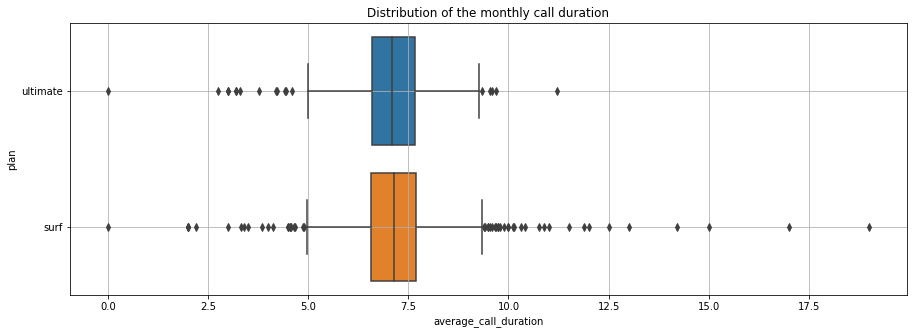

In [61]:
# Plot a boxplot to visualize the distribution of the monthly call duration

plt.figure(figsize=(15,5))
sns.boxplot( x='average_call_duration',y='plan',data=user_consumption)
plt.title('Distribution of the monthly call duration')
plt.grid()
plt.show()

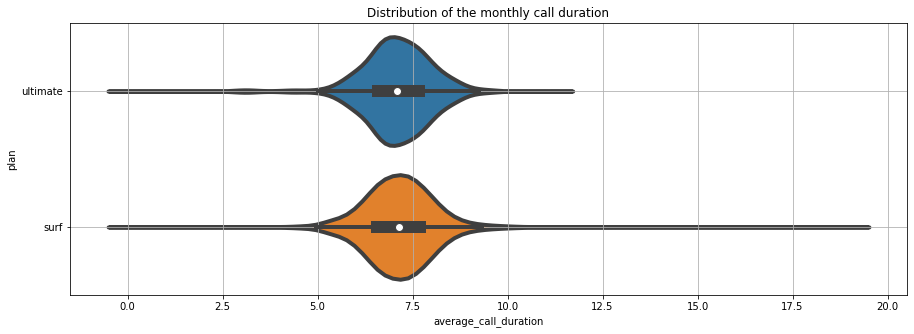

In [62]:
#And my favourite violine plot

plt.figure(figsize=(15,5))
sns.violinplot( x='average_call_duration',y='plan',data=user_consumption,linewidth = 4)
plt.title('Distribution of the monthly call duration')
plt.grid()
plt.show()

While both distributions are nearly identical, the number of outlying values in *surf* subset is bigger. That leads bigger variance inside this subset's distribution.

### Messages

* Average per month

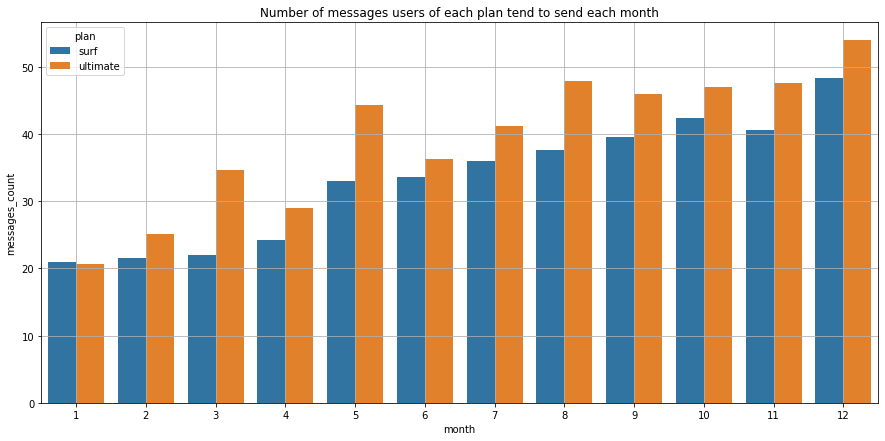

In [63]:
# Compare the number of messages users of each plan tend to send each month

messages_data_to_plot = user_consumption.groupby(['plan','month'])['messages_count'].mean().reset_index()

plt.figure(figsize = (15,7))
#plt.ylim(0, 9)
sns.barplot(data = messages_data_to_plot, hue = 'plan', x = 'month', y = 'messages_count')
plt.title('Number of messages users of each plan tend to send each month')
plt.grid()
plt.show()

The number of messages tends to be greater in *ultimate* plan, which needs to be analyzed futher.
Also an interesting observation can be made here: users of both plans send more messages in average by the end of the year then they do in year's beginning.

* Monthly average

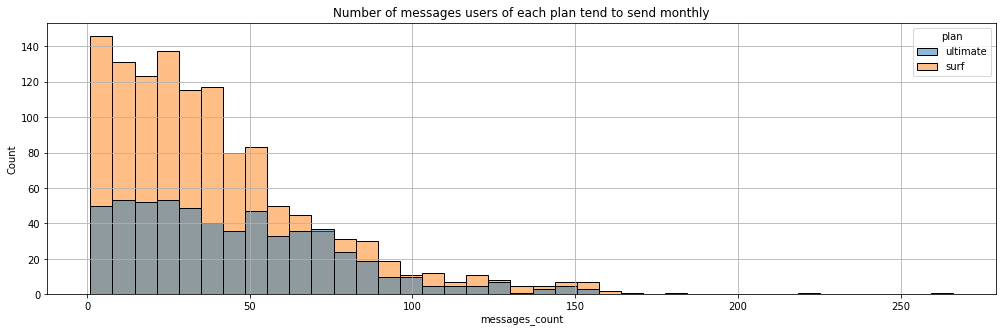

In [64]:
plt.figure(figsize=(17,5))
sns.histplot(user_consumption,x='messages_count',hue='plan')
plt.title('Number of messages users of each plan tend to send monthly')
plt.grid()
plt.show()

Both distributions are skewed to the right, but *ultimate* users shows less expressed peak (more uniform distribution) of people who send 0-75 messages in average than the users of *surf*.

In [65]:
print('Variance is:',user_consumption.groupby('plan')['messages_count'].var())
print('*'*50)
print('Standard deviation is:',user_consumption.groupby('plan')['messages_count'].std())
print('*'*50)
print('Mean is:',user_consumption.groupby('plan')['messages_count'].mean())
print('*'*50)
print('Median is:',user_consumption.groupby('plan')['messages_count'].median())

Variance is: plan
surf        1091.344231
ultimate    1085.183108
Name: messages_count, dtype: float64
**************************************************
Standard deviation is: plan
surf        33.035500
ultimate    32.942118
Name: messages_count, dtype: float64
**************************************************
Mean is: plan
surf        40.109656
ultimate    46.296233
Name: messages_count, dtype: float64
**************************************************
Median is: plan
surf        32.0
ultimate    41.0
Name: messages_count, dtype: float64


By comparing mean and median values, we can say, that *surf* subset has greater skewness, than *ultimate*. 

Also, *surf* users tend to send less messages, than *ultimate* ones. This needs futher study.

Standard deviations and variances are nearly identical for both subsets

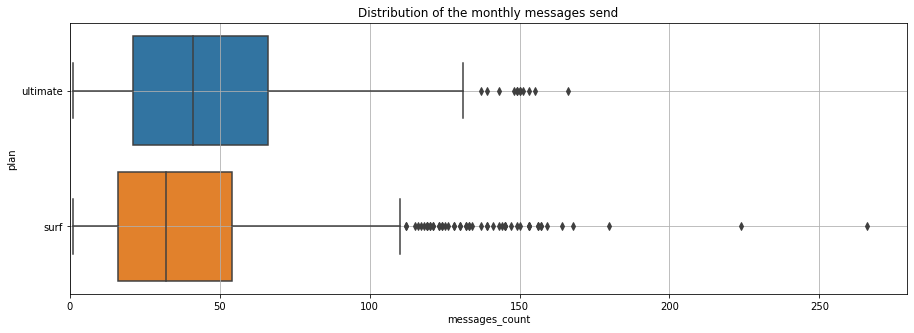

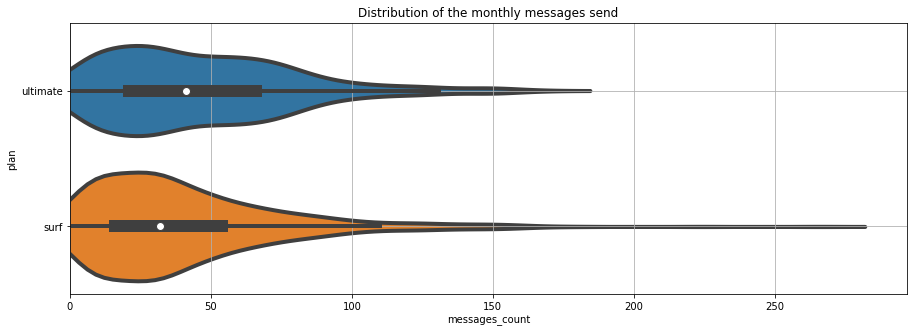

In [66]:
#And my favourite violine plot

plt.figure(figsize=(15,5))
sns.boxplot( x='messages_count',y='plan',data=user_consumption)
plt.title('Distribution of the monthly messages send')
plt.grid()
plt.xlim(0, None)
plt.show()

plt.figure(figsize=(15,5))
sns.violinplot( x='messages_count',y='plan',data=user_consumption,linewidth = 4)
plt.title('Distribution of the monthly messages send')
plt.grid()
plt.xlim(0, None)
plt.show()

*Ultimate* plan users tend to send more messages, while showing greater interqurtile range of average sent messages. 

If there is a real difference in users' messaging behaviour should be statistically tested.

* Null hypothesis: users of different plans show the same messaging behaviour
* Alternatile hypothesis: users of different plans show different messaging behaviour

In [67]:
#Normality check:
dist_mes_ult = user_consumption[(user_consumption['plan'] == 'ultimate')]['messages_count']
dist_mes_surf = user_consumption[(user_consumption['plan'] == 'surf')]['messages_count']

for subset in [dist_mes_ult,dist_mes_surf]: # Can I somehow convert this subset names to strings to put them into f-string in the print?
    stat,p = shapiro(subset)
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0) p-value is:', p)
    else:
        print('Sample does not look Gaussian (reject H0) p-value is:', p)

Sample looks Gaussian (fail to reject H0) p-value is: 1.0
Sample looks Gaussian (fail to reject H0) p-value is: 1.0


As samples are Gaussian and variances are nearly identical, the t-test for 2 independend samples can be used:

In [68]:
# Test the hypotheses
stat,p=scipy.stats.ttest_ind(dist_mes_ult,dist_mes_surf,nan_policy='omit')
alpha = 0.05
if p > alpha:
 print('We can\'t reject the Null hypothesis, p-value is:',p)
else:
 print('We can reject the null hypothesis, p-value is:',p)

We can reject the null hypothesis, p-value is: 0.00020048835621714838


*Ultimate* plan users endeed send more messages monthly.

### Internet

* Average per month

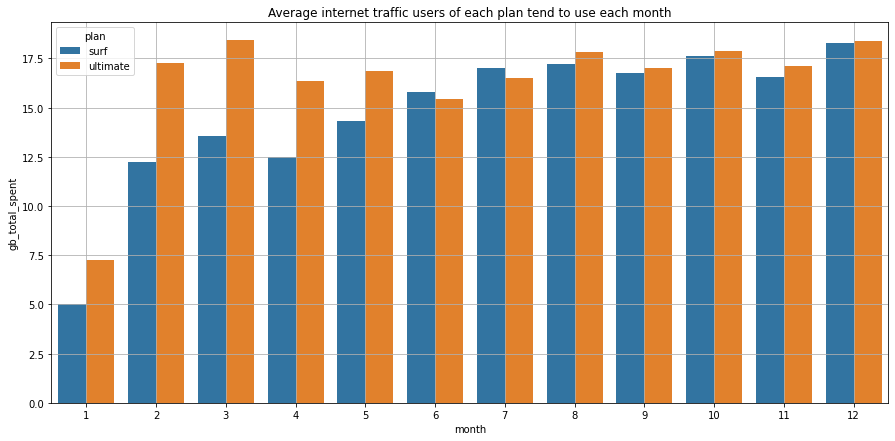

In [69]:
calls_data_to_plot = user_consumption.groupby(['plan','month'])['gb_total_spent'].agg('mean').reset_index()

plt.figure(figsize = (15,7))
sns.barplot(data = calls_data_to_plot, hue = 'plan', x = 'month', y = 'gb_total_spent')
plt.title('Average internet traffic users of each plan tend to use each month')
plt.grid()
plt.show()

Here again can be seen a difference between internet usage in the beggining of the year and in its end. But, *ultimate* users shows quite similar monthly usage from February to December with a significantly lower amount in January, while *sufr* plan users show a gradual increase in used Gbs from January to July, and then they use the same monthly amount of traffic as *ultimate* users till the end of the year.

* Monthly average

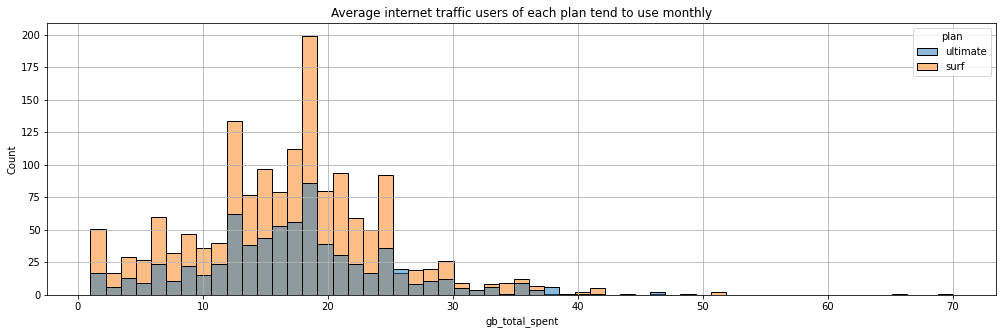

In [70]:
plt.figure(figsize=(17,5))
sns.histplot(user_consumption,x='gb_total_spent',hue='plan')
plt.title('Average internet traffic users of each plan tend to use monthly')
plt.grid()
plt.show()

*Surf* subset shows a bit bigger right-skewness, than the *ultimate* subset.
Both distributions are close to normality with some uneveness: both subsets show the same tendencies in their distributions. The biggest peaks found are: users, who use about 12 Gbs of internet monthly and those, who use about 18 Gbs.


In [71]:
print('Variance is:',user_consumption.groupby('plan')['gb_total_spent'].var())
print('Standard deviation is:',user_consumption.groupby('plan')['gb_total_spent'].std())
print('Mean is:',user_consumption.groupby('plan')['gb_total_spent'].mean())
print('Median is:',user_consumption.groupby('plan')['gb_total_spent'].median())

Variance is: plan
surf        59.473734
ultimate    58.494733
Name: gb_total_spent, dtype: float64
Standard deviation is: plan
surf        7.711922
ultimate    7.648185
Name: gb_total_spent, dtype: float64
Mean is: plan
surf        16.831194
ultimate    17.331015
Name: gb_total_spent, dtype: float64
Median is: plan
surf        17.0
ultimate    17.0
Name: gb_total_spent, dtype: float64


Both subsets shows virtually similar variances and standard deviations as well as their means and medians.

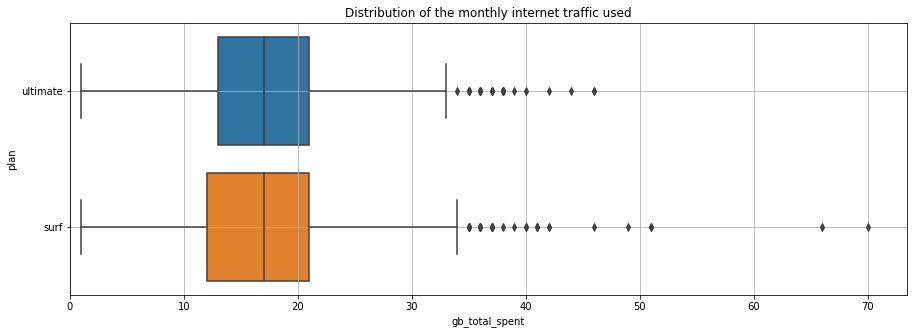

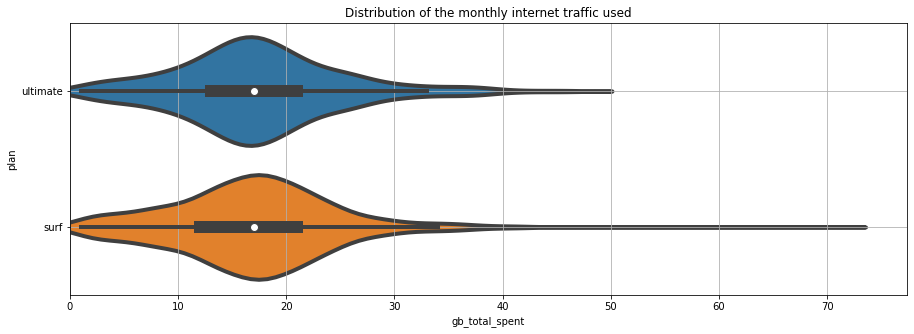

In [72]:
#And my favourite violine plot

plt.figure(figsize=(15,5))
sns.boxplot( x='gb_total_spent',y='plan',data=user_consumption)
plt.title('Distribution of the monthly internet traffic used')
plt.grid()
plt.xlim(0, None)
plt.show()

plt.figure(figsize=(15,5))
sns.violinplot( x='gb_total_spent',y='plan',data=user_consumption,linewidth = 4)
plt.title('Distribution of the monthly internet traffic used')
plt.grid()
plt.xlim(0, None)
plt.show()

Both subsets reveal identical behaviour of users of different plans. Th only difference - a bit bigger amount of extremly heavy mobile internet users in the *surf* subset, that can be a explained by the bigger sample.

**Counclusion:**

Users of both plans shows nearly identical behavior in terms of average call durations, internet traffic usage. With a high probability we can assume that messages sending behaviour indeed differs between users of the diffenet plans.|

### Revenue

* Average per month

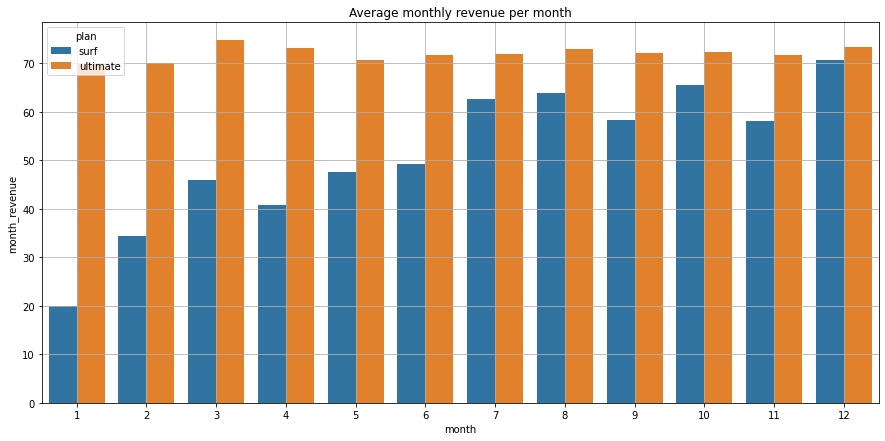

In [73]:
revenue_data_to_plot = user_consumption.groupby(['plan','month'])['month_revenue'].agg('mean').reset_index()

plt.figure(figsize = (15,7))
sns.barplot(data = revenue_data_to_plot, hue = 'plan', x = 'month', y = 'month_revenue')
plt.title('Average monthly revenue per month')
plt.grid()
plt.show()

* Monthly average

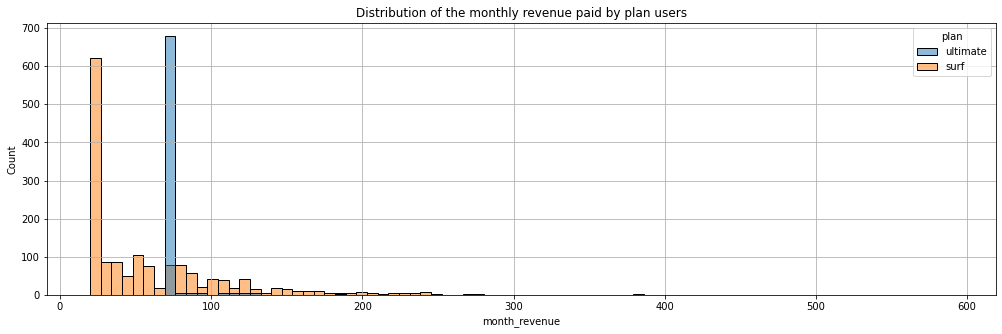

In [74]:
plt.figure(figsize=(17,5))
sns.histplot(user_consumption,x='month_revenue',hue='plan')
plt.title('Distribution of the monthly revenue paid by plan users')
plt.grid()
plt.show()

In [75]:
print('Variance is:',user_consumption.groupby('plan')['month_revenue'].var())
print('Standard deviation is:',user_consumption.groupby('plan')['month_revenue'].std())
print('Mean is:',user_consumption.groupby('plan')['month_revenue'].mean())
print('Median is:',user_consumption.groupby('plan')['month_revenue'].median())

Variance is: plan
surf        3067.835152
ultimate     129.848486
Name: month_revenue, dtype: float64
Standard deviation is: plan
surf        55.388042
ultimate    11.395108
Name: month_revenue, dtype: float64
Mean is: plan
surf        60.706408
ultimate    72.313889
Name: month_revenue, dtype: float64
Median is: plan
surf        40.36
ultimate    70.00
Name: month_revenue, dtype: float64


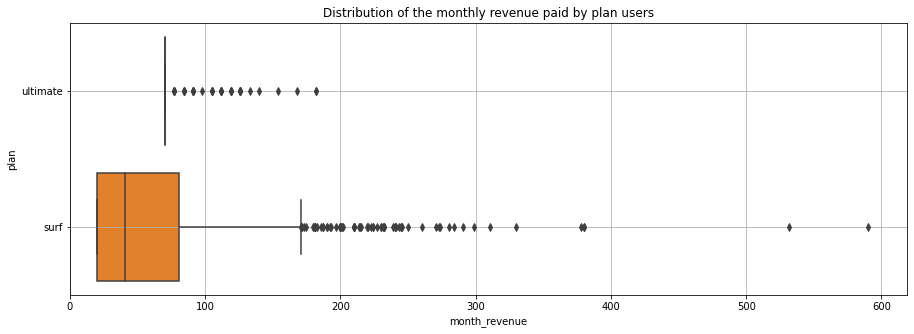

In [76]:
plt.figure(figsize=(15,5))
sns.boxplot( x='month_revenue',y='plan',data=user_consumption)
plt.title('Distribution of the monthly revenue paid by plan users')
plt.grid()
plt.xlim(0, None)
plt.show()

All the graphs and statistical measures show, that users of an *ultimate* plan has never exceeded the included amounts of minutes, Gbs and messages. So they paid the monthly revenue of 70 every month. 

Users of *surf* plan quite often used more minutes, Gbs and messages, than were included in their tariff, but they never pay more or as much as users of *ultimate* plan. In one exclusive case the biggest month revenue was less, than 55. Median is equal to the month revenue, which tells us, that 50% or more of users never exceeded the included service packages and in average pay only 22 with a standard deviation of approximately 4.

As analysis has showed, users of both plans show nearly identical behaviour, so, in most cases, it is cheaper to use *surf* plan, than *ultimate*. From the telecom company's point of wiev, it should be more profitable to sell the descriptions for *ultimate* plan. Will check it on the next step.

## Statistical hypotheses testing

* **Testing if average revenue from users of the *Ultimate* and *Surf* calling plans differs**
 * Null hypothesis: Users of both plans pay the same average revenue
 * Alternative hypothesis: Users of both plans pay different average revenue

As we have a distribution only for *Surf* plan users and all values for *Ultimate* users is 70, we can use 1 sample t-test here. 

In [78]:
surf_users = user_consumption.query('plan == "surf"')['month_revenue']
ultimate_users = user_consumption.query('plan == "ultimate"')['month_revenue']


for subset in [surf_users,ultimate_users]: 
    stat,p = shapiro(subset)
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0), p-value is:',p)
    else:
        print('Sample does not look Gaussian (reject H0), p-value is:',p)

Sample does not look Gaussian (reject H0), p-value is: 1.5414283107572988e-44
Sample does not look Gaussian (reject H0), p-value is: 0.0


In [79]:
# Test the hypotheses

stat,p = scipy.stats.mannwhitneyu(surf_users,ultimate_users)
alpha = 0.05
if p > alpha:
 print('We can\'t reject the Null hypothesis, p-value is:',p)
else:
 print('We can reject the null hypothesis, p-value is:',p)

We can reject the null hypothesis, p-value is: 1.9121793747947493e-48


**Indeed, we can assume the hypothesis, that the average revenue from users of the Ultimate and Surf calling plans differs with a big probability.**

* **Testing if average revenue from users in the NY-NJ area is different from that of the users from the other regions.**

 * Null hypothesis: Users of both area groups pay the same average revenue
 * Alternative hypothesis: Users of both area groups pay different average revenue

In order to choose the approprate test we should check the normality of both distributions.

To create both datasets we should add new column to the dataset `user_consumption` with the user's area:

In [80]:
# Addding the region information
user_consumption = user_consumption.merge(df_users[['user_id','region']], on=['user_id'], how='left')

In [81]:
user_consumption['region'].sort_values().unique()

array(['AL', 'AZ', 'CA', 'CO', 'CT', 'DC-VA-MD-WV', 'FL', 'GA', 'HI',
       'IL-IN-WI', 'IN', 'KY-IN', 'LA', 'MA-NH', 'MD', 'MI', 'MN-WI',
       'MO-IL', 'MO-KS', 'NC', 'NC-SC', 'NE-IA', 'NM', 'NV', 'NY',
       'NY-NJ-PA', 'OH', 'OH-KY-IN', 'OK', 'OR-WA', 'PA', 'PA-NJ-DE-MD',
       'RI-MA', 'SC', 'TN', 'TN-MS-AR', 'TX', 'UT', 'VA', 'VA-NC', 'WA',
       'WI'], dtype=object)

Subsets for testing:

In [82]:
dist_NY_NJ = user_consumption[(user_consumption['region'] == 'NY-NJ-PA')]['month_revenue']
dist_other_areas = user_consumption[(user_consumption['region'] != 'NY-NJ-PA')]['month_revenue']

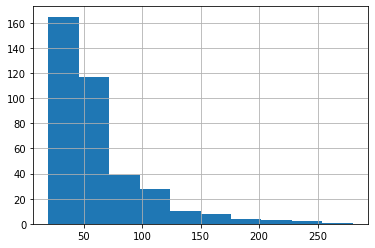

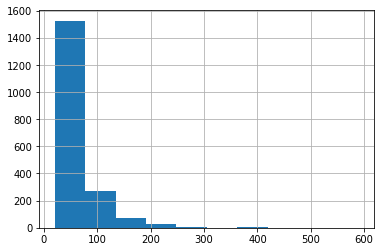

In [83]:
for subset in [dist_NY_NJ,dist_other_areas]:
    subset.hist()
    plt.show()

Revenue may be indeed different from the different areas, as in NY-NJ area there is relatively smaller amount of people, who use *ultimate* plan. This can be directly seen on the histograms by the amount of money they pay.

In [84]:
for subset in [dist_NY_NJ,dist_other_areas]: # Can I somehow convert this subset names to strings to put them into f-string in the print?
    stat,p = shapiro(subset)
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0), p-value is:',p)
    else:
        print('Sample does not look Gaussian (reject H0), p-value is:',p)

Sample does not look Gaussian (reject H0), p-value is: 9.16044367265658e-20
Sample does not look Gaussian (reject H0), p-value is: 0.0


Both distributions are not normal, so the non-parametric Mann-Whitney test should be performed here. 

In [85]:
# Test the hypotheses

stat,p = scipy.stats.mannwhitneyu(dist_NY_NJ,dist_other_areas)
alpha = 0.05
if p > alpha:
    print('We can\'t reject the Null hypothesis, p-value is:',p)
else:
    print('We can reject the null hypothesis, p-value is:',p)

We can reject the null hypothesis, p-value is: 0.003927631450027623


We can assume the hypothesis of average revenue from users in the NY-NJ area is different from that of the users from the other regions with a high probability.

**Analyzing the total revenue from different plans users**

In [86]:
print(user_consumption.groupby('plan')['month_revenue'].sum())
print(df_users.groupby('plan')['user_id'].count())

plan
surf        95491.18
ultimate    52066.00
Name: month_revenue, dtype: float64
plan
surf        339
ultimate    161
Name: user_id, dtype: int64


Even as there twice as many users of the *surf* plan, they have paid approximately 2/3 in total of the sum, that have been paid by *ultimate* plan users.

## General conclusion

* The main thing found during analyzing this project was that people telecom services usage is similar, no matter which plan they use. Only slight, but reliable difference was found in how many messages thay send monthly,
* Users of the *ultimate* plan never overuse plan's package, so they never pay more, than normal plan's monthly revenue, while about the half of the *surf* users use more services, than are provided in the plan's package. 
* For a consumers it is cheeper to use the *surf* plan, even if they overuse the plan's package's conditions. And vice versa, tha bigger revenue by the company is gained from the *ultimate* users.

The overall answer for the main qustion of the project: the *ultimate* plan should be advertized more.